In [1]:
import os
import re
from PIL import Image, ImageOps
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

import sys
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
dir_imgs = 'test_data'

In [3]:
def process_img(img):
    w, h = img.size
    s = min(w,h)

    if w > h:
        t = 0
        b = s

        l = (w - s) / 2
        r = l + s

        box = (l, t, r, b)
    else:
        t = 0
        r = s

        l = (h - s) / 2
        b = t + s

        box = (l, t, r, b)

    img = img.crop(box)
    thumbnail_size = (150, 150)
    img.thumbnail(thumbnail_size)
    # print(files_AG[i])
    # img.save(out_dir_img_AG + '/{}.jpg'.format(i), 'JPEG')
    return img

In [4]:
def predict(filename):
    print('saved :', filename)

    result_dir = 'dataset/results'

    classes = ['normal', 'AtrophicGastritis']
    nb_classes = len(classes)

    img_height, img_width = 150, 150
    channels = 3

    # VGG16
    input_tensor = Input(shape=(img_height, img_width, channels))
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

    # FC
    fc = Sequential()
    fc.add(Flatten(input_shape=vgg16.output_shape[1:]))
    fc.add(Dense(256, activation='relu'))
    fc.add(Dropout(0.5))
    fc.add(Dense(nb_classes, activation='softmax'))

    # VGG16とFCを接続
    model = Model(input=vgg16.input, output=fc(vgg16.output))

    # 学習済みの重みをロード
    model.load_weights(os.path.join(result_dir, 'finetuning.h5'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    # model.summary()

    # 画像を読み込んで4次元テンソルへ変換
    img = image.load_img(filename, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # 学習時にImageDataGeneratorのrescaleで正規化したので同じ処理が必要！
    # これを忘れると結果がおかしくなるので注意
    x = x / 255.0

    # print(x)
    # print(x.shape)

    # クラスを予測
    # 入力は1枚の画像なので[0]のみ
    pred = model.predict(x)[0]

    # 予測確率が高いトップ5を出力
    top = 2
    top_indices = pred.argsort()[-top:][::-1]
    result = [(classes[i], pred[i]) for i in top_indices]
    return result

In [5]:
def download_img(url, dir_imgs):
    list_imgs = os.listdir(dir_imgs)
    r = re.compile("[0-9]{3}\.jpg")
    list_imgs = [x for x in list_imgs if r.match(x)]
    savename = '%03d.jpg'%(max([int(x[:3]) for x in list_imgs]) + 1)
    savename = dir_imgs + '/' + savename
    urllib.request.urlretrieve(url, savename)
    return savename

In [20]:
def main(url, dir_imgs='test_data'):
    filename = download_img(url, dir_imgs)
    img = Image.open(filename)
    process_img(img).convert("RGB").save(filename, 'JPEG')
    result = predict(filename)
    img = Image.open(filename)
    plt.imshow(np.array(img))
    return result

saved : test_data/065.jpg


/home/yyoshiaki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


saved : test_data/066.jpg
saved : test_data/067.jpg
saved : test_data/068.jpg
saved : test_data/069.jpg
saved : test_data/070.jpg
saved : test_data/071.jpg
saved : test_data/072.jpg
539 ms ± 41.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


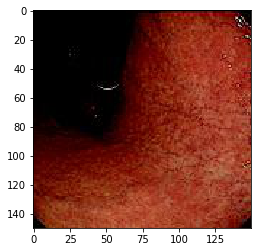

In [28]:
%timeit main('https://d11o9kmqc23yug.cloudfront.net/data/qpics/production/image/1063/106F-05.jpg')

In [23]:
result_dir = 'dataset/results'

classes = ['normal', 'AtrophicGastritis']
nb_classes = len(classes)

img_height, img_width = 150, 150
channels = 3

# VGG16
input_tensor = Input(shape=(img_height, img_width, channels))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# FC
fc = Sequential()
fc.add(Flatten(input_shape=vgg16.output_shape[1:]))
fc.add(Dense(256, activation='relu'))
fc.add(Dropout(0.5))
fc.add(Dense(nb_classes, activation='softmax'))

# VGG16とFCを接続
model = Model(input=vgg16.input, output=fc(vgg16.output))

# 学習済みの重みをロード
model.load_weights(os.path.join(result_dir, 'finetuning.h5'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/home/yyoshiaki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)